In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data preparation

In [9]:
mat = scipy.io.loadmat('ch_cell.mat')
meta_data = scipy.io.loadmat('resp_cell.mat')

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\io\matlab\mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [10]:
ch = mat['ch_cell'] #### num_tx by num_rx
dist =mat['dist']

cir_profile = meta_data['resp_cell']

In [66]:
x, y = meta_data['X'].flatten(), meta_data['Y'].flatten()
Y = np.array([x, y]).T

In [16]:
meta_data['dist'].shape, dist.shape, cir_profile.shape

((1, 20), (400, 4), (400, 4))

In [67]:
ray_len = []

for chs in cir_profile:
    for ch in chs:
        ray_len.append(len(ch[0,:]))

max_reflection = max(ray_len)


Text(0.5, 0, '#-of-raytraces')

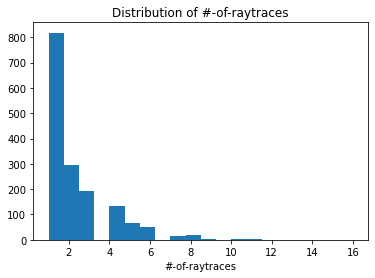

In [31]:
plt.hist(ray_len, bins=20)
plt.title('Distribution of #-of-raytraces')
plt.xlabel('#-of-raytraces')

In [73]:
np.pad(cir_profile[0][0], (2, 16), constant_values=0)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0,

In [103]:
# prepare X

T, S = cir_profile.shape
x_pre = []
for j in range(T):
    cir_t = [] # channel impulse response for a transmitter
    for i in range(S):
        c_tmp = cir_profile[j, i]
        m, n = c_tmp.shape
        cir_shaped = np.pad(c_tmp, \
            ((0,2-m), (0, max_reflection-n)), \
                constant_values=0).flatten() # padding 0 to shape of (2, max_len)
        cir_t.append(cir_shaped)

    x_pre.append(np.array(cir_t).flatten())

X = np.array(x_pre)  

# Learning

In [105]:
X.shape, Y.shape

((400, 128), (400, 2))